In [1]:
import pandas as pd

df = pd.read_csv('data/shopee_reviews.csv')

/usr/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3444: DtypeWarning: Columns (0) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [2]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1502575 entries, 0 to 1502574
Data columns (total 2 columns):
 #   Column  Non-Null Count    Dtype 
---  ------  --------------    ----- 
 0   label   1502575 non-null  object
 1   text    1502575 non-null  object
dtypes: object(2)
memory usage: 22.9+ MB


In [3]:
df[:10]

,label,text
0,5,Looks ok. Not like so durable. Will hv to use ...
1,5,"Tried, the current can be very powerful depend..."
2,5,Item received after a week. Looks smaller than...
3,5,Thanks!!! Works as describe no complaints. Not...
4,5,Fast delivery considering it’s from overseas a...
5,5,Fast delivery good service
6,5,Got my order and it came well packaged. Have y...
7,5,Items received in a nice box. Have not used it...
8,5,"Received in good condition, tried so far so go..."
9,1,Item doesn’t work . \n\nAsked me to send a ref...


In [4]:
reviews = df['text']
reviews.shape

(1502575,)

#### Предобработка текста

In [5]:
from typing import List
from collections import Counter
from itertools import chain

def build_vocab(texts: List[str]) -> Counter:
    words = list(chain.from_iterable([text.split() for text in texts]))
    vocab = Counter(words)
    return vocab

In [6]:
vocab = build_vocab(reviews)
print(len(vocab))
# слова разного регистра
list(vocab.items())[:10]

342808


[('Looks', 23179),
 ('ok.', 15341),
 ('Not', 32351),
 ('like', 63581),
 ('so', 102367),
 ('durable.', 1222),
 ('Will', 84734),
 ('hv', 1257),
 ('to', 473417),
 ('use', 42793)]

In [7]:
# natural language toolkit
import nltk
nltk.download('stopwords')

from nltk.corpus import stopwords

eng_stopwords = stopwords.words('english')
print(len(eng_stopwords))
eng_stopwords[:10]

179


[nltk_data] Downloading package stopwords to /home/rytuo/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're"]

In [8]:
# удалим стоп-слова
eng_stopwords = set(eng_stopwords)

def preprocess_text(text: str) -> str:
    text = text.lower()
    is_allowed_char = lambda c: c.isalpha() or c == ' '
    text = ''.join(list(filter(is_allowed_char, text)))
    
    is_stopword = lambda word: word not in eng_stopwords
    text = ' '.join(list(filter(is_stopword, text.split())))
    return text


reviews = [preprocess_text(review) for review in reviews]

In [9]:
vocab = build_vocab(reviews)
        
print(len(vocab))
# уже лучше. Но есть стоп-слова самого корпуса
vocab.most_common(10)

155590


[('good', 617936),
 ('delivery', 401430),
 ('received', 396088),
 ('fast', 323513),
 ('item', 246937),
 ('well', 214772),
 ('seller', 214642),
 ('condition', 210077),
 ('quality', 183978),
 ('nice', 133451)]

In [10]:
# Посмотрим сколько уникальных слов

def merge_reviews(reviews: list[str]) -> str:
    return ' '.join(reviews)
    
    
unique_words =list(set(merge_reviews(reviews).split(' ')))
len(unique_words)

155591

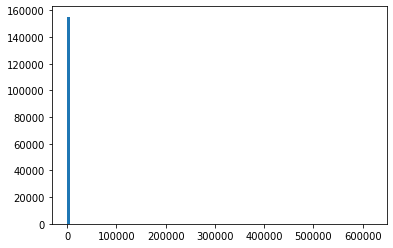

In [11]:
import matplotlib.pyplot as plt
# Оставим частые слова

from collections import Counter

counts = Counter(merge_reviews(reviews).split(' '))
freqs = list(counts.values())
plt.hist(freqs, bins=100)
plt.show()

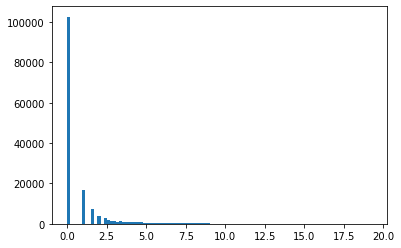

In [12]:
import numpy as np

plt.hist(np.log2(freqs), bins=100)
plt.show()

In [13]:
from tqdm import tqdm
nltk.download('wordnet')
nltk.download('omw-1.4')
from nltk.stem import WordNetLemmatizer

lemmatizer = WordNetLemmatizer()

def lemmatizing(text):
    text = ' '.join(list(map(lemmatizer.lemmatize, text.split())))
    return text

reviews_lem = [lemmatizing(review) for review in tqdm(reviews, leave=True, position=0)]
reviews_lem[:10]

[nltk_data] Downloading package wordnet to /home/rytuo/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /home/rytuo/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
100%|██████████████████████████████| 1502575/1502575 [01:02<00:00, 24068.91it/s]


['look ok like durable hv use recommend others worth',
 'tried current powerful depending setting dont dare go higher go higher sure muscle become sore see effect faster',
 'item received week look smaller expected cant wait try',
 'thanks work describe complaint really expecting life changing result thanks',
 'fast delivery considering overseas tried sure result yet',
 'fast delivery good service',
 'got order came well packaged yet try look good far thanks',
 'item received nice box used yet hopefully work',
 'received good condition tried far good bad',
 'item doesnt work asked send refund show non working machine deem enough evidence dont waste time buying']

### gensim

In [14]:
# Для простоты реализации воспользуемся библиотекой gensim

from gensim.models import Word2Vec

sentences = [review.split() for review in reviews_lem]
model = Word2Vec(sentences=sentences,
                 sg=False,  # cbow model
                 vector_size=100,
                 window=5,
                 seed=42,
                 epochs=15, 
                 min_count=1
                 )
print('размерность векторов слов в модели:', model.wv.vectors.shape)

размерность векторов слов в модели: (150387, 100)


### BERT

In [23]:
import torch
from transformers import BertTokenizer, BertModel

tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

# Load pre-trained model (weights)
model_bert = BertModel.from_pretrained('bert-base-uncased',
                                  output_hidden_states = True, # возращать эмбеддинги каждого слова
                                  )
model_bert.eval()
print('done')

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


done


# Tests

## gensim

взятие ближайшего

In [62]:
model.wv.most_similar(positive=lemmatizing('boy'), topn=5)

[('girl', 0.940083384513855),
 ('son', 0.9233588576316833),
 ('daughter', 0.914170503616333),
 ('gal', 0.9084888100624084),
 ('kid', 0.8560245037078857)]

In [63]:
model.wv.most_similar(positive=lemmatizing('fast'), topn=5)

[('quick', 0.8983880877494812),
 ('speedy', 0.8327916264533997),
 ('prompt', 0.7884963154792786),
 ('swift', 0.6818633079528809),
 ('fastthe', 0.6715322732925415)]

взятие дальнейшего

In [64]:
model.wv.most_similar(negative=lemmatizing('boy'), topn=5)

[('gooooooooooooooooooooooooooddddd', 0.3776337802410126),
 ('loca', 0.34653955698013306),
 ('bubblewrapped', 0.3448903262615204),
 ('newfresh', 0.3386460244655609),
 ('wellpackaged', 0.32754573225975037)]

In [65]:
model.wv.most_similar(negative=lemmatizing('fast'), topn=5)

[('soonnewborn', 0.38630419969558716),
 ('deliverywill', 0.366961270570755),
 ('delirverythks', 0.3538437783718109),
 ('delievry', 0.3526564836502075),
 ('deliveryand', 0.3521786332130432)]

In [66]:
def sum_words_gensim(w1, w2):
    w1 = lemmatizing(w1)
    w2 = lemmatizing(w2)
    return model.wv.get_vector(w1) + model.wv.get_vector(w2)

def sub_words_gensim(w1, w2):
    w1 = lemmatizing(w1)
    w2 = lemmatizing(w2)
    return model.wv.get_vector(w1) - model.wv.get_vector(w2)

сумма

In [67]:
model.wv.most_similar(positive=sum_words_gensim('fast', 'delivery'), topn=5)

[('delivery', 0.6081157326698303),
 ('fast', 0.6070573329925537),
 ('efficient', 0.5202959775924683),
 ('quick', 0.5065531134605408),
 ('shipping', 0.5040369033813477)]

In [68]:
model.wv.most_similar(positive=sum_words_gensim('male', 'kid'), topn=5)

[('kid', 0.896405041217804),
 ('child', 0.8603538274765015),
 ('girl', 0.799560010433197),
 ('boy', 0.7986191511154175),
 ('toddler', 0.783473551273346)]

разность

In [69]:
model.wv.most_similar(positive=sub_words_gensim('fast', 'delivery'), topn=5)

[('fast', 0.794016420841217),
 ('quick', 0.7430314421653748),
 ('speedy', 0.7336267232894897),
 ('prompt', 0.6393364071846008),
 ('swift', 0.60210782289505)]

In [70]:
model.wv.most_similar(positive=sub_words_gensim('male', 'kid'), topn=5)

[('lowtheres', 0.448456734418869),
 ('breezyrecommend', 0.4029383957386017),
 ('dermomed', 0.3838895559310913),
 ('lululemon', 0.3699968755245209),
 ('longhonestly', 0.3615322709083557)]

In [71]:
model.wv.most_similar(positive=sub_words_gensim('kid', 'male'), topn=5)

[('kid', 0.8290750980377197),
 ('child', 0.792592465877533),
 ('son', 0.7472835779190063),
 ('kiddos', 0.7196148037910461),
 ('daughter', 0.7028495669364929)]

## Bert

In [24]:
from itertools import chain
from tqdm import tqdm

words = list(chain.from_iterable([text.split() for text in reviews]))
words = list(set(words))
len(words)

155590

In [25]:
# incapsulate to function

def get_word_embedding(word: str) -> torch.Tensor:
    # Получим индексы токенов
    tokenized_word = tokenizer.tokenize(word)
    indexed_tokens = tokenizer.convert_tokens_to_ids(tokenized_word)
    segments_ids = [1] * len(indexed_tokens)
    
    # to tensor 
    tokens_tensor = torch.tensor([indexed_tokens])
    segments_tensors = torch.tensor([segments_ids])
    
    # calc embeddings
    outputs = model_bert(tokens_tensor, segments_tensors)
    embeddings = outputs[2]
    last_layer_embs = embeddings[-1]
    word_embedding = last_layer_embs.squeeze(0).sum(dim=0)
    return word_embedding

word_embs = []

get_word_embedding('testing')

for word in tqdm(words[:500], leave=True, position=0):
    emb = get_word_embedding(word)
    word_embs.append(emb)

100%|█████████████████████████████████████████| 500/500 [00:24<00:00, 20.01it/s]


In [26]:
words_embs = torch.stack(word_embs)

words_embs.size()

torch.Size([500, 768])

In [49]:
def get_similar_bert(word_emb, topn=5):
    li = torch.nn.functional.cosine_similarity(word_emb, words_embs).tolist()
    inds = sorted(range(len(li)), key=lambda k: li[k], reverse=True)[:topn]
    return [words[ind] for ind in inds]

def get_opposite_bert(word_emb, topn=5):
    li = torch.nn.functional.cosine_similarity(word_emb, words_embs).tolist()
    inds = sorted(range(len(li)), key=lambda k: li[k])[:topn]
    return [words[ind] for ind in inds[:topn]]

def sum_words_bert(w1, w2):
    return get_word_embedding(w1) + get_word_embedding(w2)

def sub_words_bert(w1, w2):
    return get_word_embedding(w1) - get_word_embedding(w2)

взятие ближайшего

In [51]:
get_similar_bert(get_word_embedding('boy'))

['fishtank', 'okaround', 'slove', 'flood', 'panelvery']

In [52]:
get_similar_bert(get_word_embedding('fast'))

['fastpleased', 'tooeach', 'thephone', 'homebuttonpower', 'lightrefresh']

взятие дальнейшего

In [53]:
get_opposite_bert(get_word_embedding('boy'))

['symbolize', 'thinq', 'sellerkeep', 'discountpromo', 'decprice']

In [54]:
get_opposite_bert(get_word_embedding('fast'))

['emirates',
 'complains',
 '很漂亮颜色和图片的一样质量也ok只是号码偏大了我已经买小一号了可是还是大了',
 'xhpg',
 '希望这个产品能让我的宝贝的背快快变好']

In [55]:
get_similar_bert(sum_words_bert('fast', 'delivery'))

['pictureoverall', 'cracknot', 'deliverylong', 'fishtank', 'necklines']

In [56]:
get_similar_bert(sum_words_bert('male', 'kid'))

['rumi', 'iu', 'pipi', 'advertisementand', 'promptlythank']

In [57]:
get_similar_bert(sub_words_bert('fast', 'delivery'))

['clouded', 'gsk', 'koreanotified', 'wooorth', 'gavin']

In [58]:
get_similar_bert(sub_words_bert('wonderful', 'fast'))

['advertisedtks', 'aromatica', 'assets', 'ofr', 'orangeyd']

Вывод: берт натренировать сложнее, поэтому word2vec получился более рабочий

In [55]:
word2cnt = dict()

for sentence in sentences:
    for word in sentence:
        if word2cnt.get(word) is None:
            word2cnt[word] = 0
        word2cnt[word] = word2cnt[word] + 1
        
popular_words = list(map(lambda x: x[0], sorted(list(word2cnt.items()), key=lambda x: x[1])[-2000:]))

popular_words_wv = [model.wv.word_vec(word) for word in popular_words]

/tmp/ipykernel_9867/2054020519.py:11: DeprecationWarning: Call to deprecated `word_vec` (Use get_vector instead).
  popular_words_wv = [model.wv.word_vec(word) for word in popular_words]


In [56]:
from tensorboardX import SummaryWriter

writer = SummaryWriter('popular_gensim')
writer.add_embedding(popular_words_wv, metadata=popular_words)
writer.close()

In [ ]:
from tensorboardX import SummaryWriter

writer = SummaryWriter('gensim')
writer.add_embedding(model.wv.vectors, metadata=model.wv.index_to_key)
writer.close()